In [ ]:
!pip install web3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.5/515.5 kB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of eth-rlp to determine which version is compatible with other requi

In [ ]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: using Google CoLab
Using device: cpu


# Training Model for Prediction of Gas Price


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from web3 import Web3
from sklearn.model_selection import train_test_split

# Connect to an Ethereum node using Web3
w3 = Web3(Web3.HTTPProvider('https://mainnet.infura.io/v3/e41780b7bd33468f8591d3eac73121d1'))


In [ ]:
# Fetch Block Data

# Define a function to fetch the latest 100 blocks and their transactions
def fetch_ethereum_data():
    latest_blocks = w3.eth.get_block_number()
    # print(latest_blocks)
    blocks_data = []
    transactions_data = []
    for i in range(latest_blocks-100, latest_blocks):  # Fetching the latest 100 blocks
        block = w3.eth.get_block(i, True)  # True for full transactions data
        blocks_data.append(block)
        transactions_data.extend(block.transactions)
    return blocks_data, transactions_data

In [ ]:
# Step 1: Fetch Ethereum transaction data
blocks_data, transactions_data = fetch_ethereum_data()

In [ ]:
print((transactions_data[0]))
print(transactions_data[0].blockNumber)
print(transactions_data[len(transactions_data)-1].blockNumber)
print((transactions_data[0].gasPrice))
print(type(transactions_data))
# for row in transactions_data:
#   print(row.blockNumber)
#   # break

AttributeDict({'accessList': [], 'blockHash': HexBytes('0xc25ee8392f3624fca2dfeb7712ad4a200cec81a08d53f322906c0f6c68187455'), 'blockNumber': 19495105, 'chainId': 1, 'from': '0x664d8F8F2417F52CbbF5Bd82Ba82EEfc58a87f07', 'gas': 261149, 'gasPrice': 25743897774, 'hash': HexBytes('0xd8d609284d07fdf06c1ed483ffbbae332dff928edd3ad7918fae495e20dbf5f9'), 'input': HexBytes('0x65b2489b0000000000000000000000000000000000000000000000000000000000000002000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000d3c21bcecceda10000000000000000000000000000000000000000000000000001d39a7f99db048dbcca'), 'maxFeePerGas': 150000000000, 'maxPriorityFeePerGas': 4400000000, 'nonce': 5847, 'r': HexBytes('0x249c32e8d6b67a22786aa9d83a39af8d132eb9cf552af8179b57ad05e7d95ce9'), 's': HexBytes('0x153b90a0e05fbee2d513adb02c9a9a9401baf4af26526f9efca840d0f279abfe'), 'to': '0xDB6925eA42897ca786a045B252D95aA7370f44b4', 'transactionIndex': 0, 'type': 2, 'v': 1, 'value': 0, 'yParit

In [ ]:
import pandas as pd

df = pd.DataFrame(transactions_data)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

print(len(transactions_data))
print(len(df))
df['gasPrice'] = df['gasPrice'].astype(float)
df_train = df[df['blockNumber'] < 19495185]
df_test = df[df['blockNumber'] >= 19495185]
print(len(df_train))
print(len(df_test))

spots_train = df_train['gasPrice'].to_numpy().reshape(-1, 1)
spots_test = df_test['gasPrice'].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
spots_train = scaler.fit_transform(spots_train).flatten().tolist()
spots_test = scaler.transform(spots_test).flatten().tolist()

20234
20234
16316
3918


In [ ]:
# Sequence Data Preparation
SEQUENCE_SIZE = 15

def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, spots_test)

# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [ ]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=100, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

model = TransformerModel().to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/1000, Validation Loss: 0.0234
Epoch 2/1000, Validation Loss: 0.0235
Epoch 3/1000, Validation Loss: 0.0241
Epoch 4/1000, Validation Loss: 0.0235
Epoch 5/1000, Validation Loss: 0.0245
Early stopping!


In [ ]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 27519169644.5576


In [ ]:
import pickle
with open('TransformerModel.pkl', 'wb') as file:
    # Serialize and save the model to the file
    pickle.dump(model, file)

In [ ]:
# Model definition
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=100, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(100, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = LSTMModel().to(device)



In [ ]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/1000, Validation Loss: 0.0233
Epoch 2/1000, Validation Loss: 0.0233
Epoch 3/1000, Validation Loss: 0.0233
Epoch 4/1000, Validation Loss: 0.0234
Epoch 5/1000, Validation Loss: 0.0234
Early stopping!


In [ ]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 26179434558.7947


In [ ]:
import pickle
with open('LSTMModel.pkl', 'wb') as file:
    # Serialize and save the model to the file
    pickle.dump(model, file)

In [ ]:
# Standard Scaling the Gas Prices
import numpy as np
gas_prices = []

for row in transactions_data:
  gas_prices.append(row.gasPrice)
mean = np.mean(gas_prices)
std_dev = np.std(gas_prices)
print("Mean:", mean)
print("Std Dev:", std_dev)

print(gas_prices[0])
for i in range(len(gas_prices)):
  gas_prices[i] = (gas_prices[i] - mean) / std_dev
print(gas_prices[0])

Mean: 23627975790.838917
Std Dev: 17417569923.77125
20222026727
-0.19554674267106148


In [ ]:

# Step 2: Process data and prepare sequences for training
def prepare_sequences(gas_prices):
    sequences = []
    for i in range(len(gas_prices) - 16):  # For each transaction, take the last 15 transactions
        sequence = []
        for j in range(15):
            sequence.append(gas_prices[i + j])
        sequences.append(sequence)
    return sequences

# Prepare sequences for training
sequences = prepare_sequences(gas_prices)
# print(sequences)

# Convert sequences to numpy array
sequences_scaled = np.array(sequences)

In [ ]:
sequences_scaled.shape

(19142, 15)

In [ ]:
X_train = np.reshape(sequences_scaled[:, :-1], (sequences_scaled.shape[0], sequences_scaled.shape[1]-1, 1))
y_train = sequences_scaled[:, -1]  # Gas price of the next transaction

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:

# Step 3: Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))

# Compile the model with a lower learning rate
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 4: Training the LSTM model
model.fit(X_train, y_train, epochs=20, batch_size=32)


Epoch 1/20
479/479 [==============================] - 5s 4ms/step - loss: 1.0809
Epoch 2/20
479/479 [==============================] - 2s 5ms/step - loss: 1.0766
Epoch 3/20
479/479 [==============================] - 3s 6ms/step - loss: 1.0752
Epoch 4/20
479/479 [==============================] - 2s 4ms/step - loss: 1.0753
Epoch 5/20
479/479 [==============================] - 2s 4ms/step - loss: 1.0745
Epoch 6/20
479/479 [==============================] - 2s 4ms/step - loss: 1.0729
Epoch 7/20
479/479 [==============================] - 2s 4ms/step - loss: 1.0729
Epoch 8/20
479/479 [==============================] - 2s 4ms/step - loss: 1.0719
Epoch 9/20
479/479 [==============================] - 3s 6ms/step - loss: 1.0711
Epoch 10/20
479/479 [==============================] - 2s 5ms/step - loss: 1.0704
Epoch 11/20
479/479 [==============================] - 2s 4ms/step - loss: 1.0680
Epoch 12/20
479/479 [==============================] - 2s 4ms/step - loss: 1.0687
Epoch 13/20
479/479 [====

In [ ]:
def inv_transform(y_pred):
  y = y_pred.copy()
  for i in range(len(y)):
    y[i] = (y[i]*std_dev) + mean
  return y

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 5: Evaluate the model on the test data
y_pred = model.predict(X_test)

print(y_pred)
y_pred_inv = inv_transform(y_pred)
y_test_inv = inv_transform(y_test)
print(y_pred)
# print(y_test)
# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


120/120 [==============================] - 1s 3ms/step
[[-0.15307786]
 [ 0.27267206]
 [ 0.04594466]
 ...
 [-0.0502683 ]
 [ 0.16403009]
 [ 0.28011   ]]
[[-0.15307786]
 [ 0.27267206]
 [ 0.04594466]
 ...
 [-0.0502683 ]
 [ 0.16403009]
 [ 0.28011   ]]
Mean Squared Error (MSE): 0.487200579831892
Mean Absolute Error (MAE): 0.10910963333471421


# Transformer Model

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
# Setup data loaders for batch
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

TypeError: 'int' object is not callable

In [ ]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

model = TransformerModel().to(device)

In [ ]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")



In [ ]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

In [ ]:
!pip install pytorch-lightning

In [ ]:
print(type(y_pred))

<class 'numpy.ndarray'>


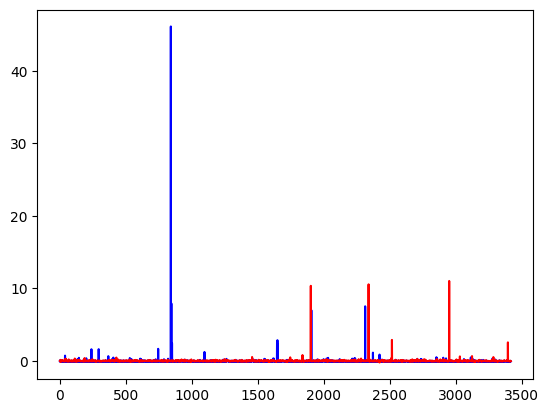

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
plt.plot(y_test, color='blue', linestyle='-')
plt.plot(y_pred, color='red', linestyle='-')
plt.show()

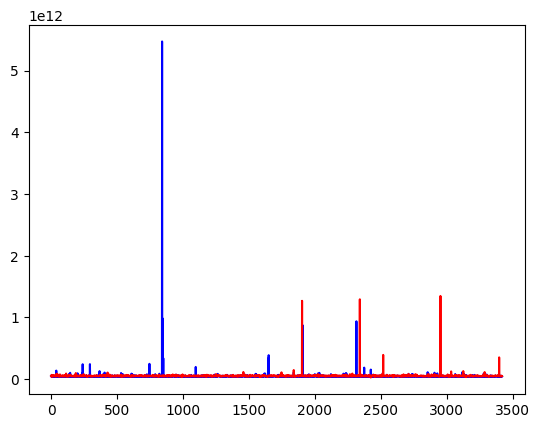

In [ ]:

plt.plot(y_test_inv, color='blue', linestyle='-')
plt.plot(y_pred_inv, color='red', linestyle='-')
plt.show()

In [ ]:
print(gas_prices[0])
gas_prices_inv = inv_transform(gas_prices)
print(gas_prices_inv[0])

-0.0007450980657294198
52097368862.0


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Assuming your time series data is stored in the variable 'time_series_data'

# Perform the ADF test
result = adfuller(gas_prices_inv)

# Extract the test statistic and p-value from the result
adf_statistic = result[0]
p_value = result[1]

# Print the results
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis. The data is stationary.")
else:
    print("Fail to reject the null hypothesis. The data is not stationary.")


ADF Statistic: -84.6240702359353
p-value: 0.0
Reject the null hypothesis. The data is stationary.


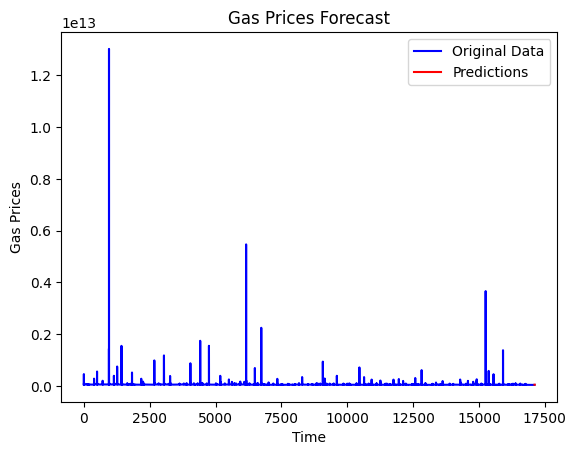

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

gas_prices_series = pd.Series(gas_prices_inv)
# Define the ARIMA model parameters (p, d, q)
p = 5  # Autoregression (AR) order
d = 1  # Integration (I) order
q = 5  # Moving Average (MA) order

# Instantiate and fit the ARIMA model
arima_model = ARIMA(gas_prices_series, order=(p, d, q))
arima_result = arima_model.fit()

# Specify the number of steps to forecast
forecast_steps = 10  # Adjust this as needed

# Make predictions
predictions = arima_result.forecast(steps=forecast_steps)

# # Plot the original data and the predictions
plt.plot(gas_prices_series, color='blue', label='Original Data')
plt.plot(range(len(gas_prices_series), len(gas_prices_series) + forecast_steps), predictions, color='red', label='Predictions')
plt.xlabel('Time')
plt.ylabel('Gas Prices')
plt.title('Gas Prices Forecast')
plt.legend()
plt.show()


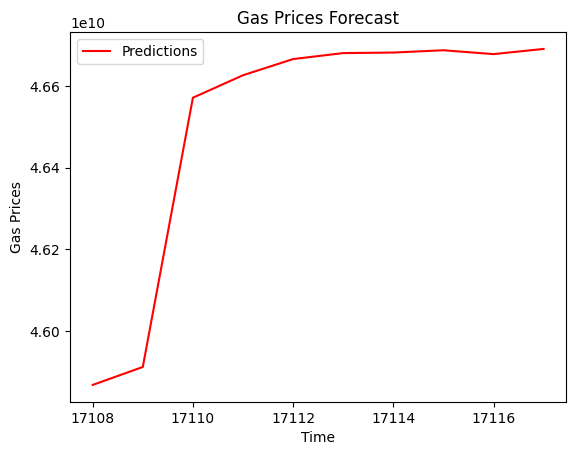

In [ ]:
plt.plot(range(len(gas_prices_series), len(gas_prices_series) + forecast_steps), predictions, color='red', label='Predictions')
plt.xlabel('Time')
plt.ylabel('Gas Prices')
plt.title('Gas Prices Forecast')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import numpy as np


# Step 3: Build the TCN model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(64, kernel_size=3, padding='causal', activation='relu')(inputs)
x = Conv1D(32, kernel_size=3, padding='causal', activation='relu')(x)
x = Flatten()(x)
outputs = Dense(1)(x)

# Create the model
model2 = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and mean squared error loss
model2.compile(optimizer=Adam(), loss='mean_squared_error')

# Step 4: Training the TCN model
model2.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_loss', patience=3)])


Epoch 1/10
431/431 [==============================] - 3s 5ms/step - loss: 2.4205e-04 - val_loss: 8.6452e-05
Epoch 2/10
431/431 [==============================] - 2s 5ms/step - loss: 2.2406e-05 - val_loss: 6.4111e-06
Epoch 3/10
431/431 [==============================] - 3s 7ms/step - loss: 4.5188e-06 - val_loss: 4.7559e-06
Epoch 4/10
431/431 [==============================] - 3s 8ms/step - loss: 5.1458e-06 - val_loss: 8.0763e-06
Epoch 5/10
431/431 [==============================] - 2s 5ms/step - loss: 6.9926e-06 - val_loss: 2.1418e-05
Epoch 6/10
431/431 [==============================] - 2s 4ms/step - loss: 1.0658e-05 - val_loss: 7.1648e-06


In [ ]:
# Make predictions on the training data\
y_pred = model2.predict(X_train)
print(y_pred.shape)
y_pred = y_pred.reshape(-1, 1)
print(y_pred.shape)
# # Inverse transform the scaled predictions to the original scale
y_pred_inv = scaler.inverse_transform(y_pred)

# # Optionally, you may also inverse transform the true values for comparison
# y_true_inv = scaler.inverse_transform(y_train.reshape(-1, 1))

# # Now you can compare the predicted and true values
# # For example, you can print the first few predictions and true values
# for i in range(10):
#     print(f"Predicted: {y_pred_inv[i][0]}, True: {y_true_inv[i][0]}")


NameError: name 'self' is not defined

In [ ]:
print(transactions_data[0])

AttributeDict({'accessList': [], 'blockHash': HexBytes('0xb2f5d5d26db6ccbaf38273e842d0a84a7e02e296eeef76fa8387ac06d0b18271'), 'blockNumber': 19216644, 'chainId': 1, 'from': '0x3511f837687Ff7272A39a231Cac1452Ad71141Fa', 'gas': 500000, 'gasPrice': 39154085283, 'hash': HexBytes('0x4f5a3b56c65a55cda3f0246c12d656e93821a514519b6aee660810022fb3d426'), 'input': HexBytes('0x791ac94700000000000000000000000000000000000000000000000000000068151fab5e00000000000000000000000000000000000000000000000016b98b4768c103e600000000000000000000000000000000000000000000000000000000000000a00000000000000000000000003511f837687ff7272a39a231cac1452ad71141fa0000000000000000000000000000000000000000000000000000000065caed8200000000000000000000000000000000000000000000000000000000000000020000000000000000000000000258f474786ddfd37abce6df6bbb1dd5dfc4434a000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'), 'maxFeePerGas': 44055688309, 'maxPriorityFeePerGas': 21000000000, 'nonce': 35337, 'r': HexBytes('0xf65ad51da

In [ ]:
# y_pred = model.predict(X_test)
# # print(y_pred)
# # y_pred_inv = np.transpose(y_pred)
# # print((y_pred_inv).shape)
# print((y_test).shape)
# print(y_test)
# # Now you can evaluate the model's performance using appropriate metrics
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)

# print("Mean Squared Error (MSE):", mse)
# print("Mean Absolute Error (MAE):", mae)
print(len(y_test))
print(len(y_test) + len(y_train))
print(len(transactions_data))

3305
16522
16538


In [ ]:
# Use the trained model to make predictions on the test data
y_pred = model.predict(X_test)

y_pred = np.reshape(y_pred, (y_pred.shape[0],))
print(y_pred.shape)
print(y_test)
# Since you scaled the data, you need to inverse transform the predictions
# y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)  # Reshape y_pred to (num_samples, 1)

# You might want to inverse transform the true values of y_test as well for comparison
# y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

# Now you can evaluate the model's performance using appropriate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


104/104 [==============================] - 1s 5ms/step
(3305,)
[0.00188787 0.00195211 0.00163576 ... 0.0020145  0.0003052  0.00206802]
Mean Squared Error (MSE): 1.6072547107251213e-07
Mean Absolute Error (MAE): 0.000323198969805201


In [ ]:
import pickle
with open('model.pkl', 'wb') as file:
    # Serialize and save the model to the file
    pickle.dump(model, file)

## Creating Feature Vector

In [ ]:
# Calculating Mean Gas Price of Transactions in the Last 10 Blocks

# print(blocks_data[10].transactions[0].blockNumber)
avg_gasPrice = {}

for block_data in blocks_data:
  # print(block_data.number)
  cur_gas_sum = 0
  for transaction in block_data.transactions:
    cur_gas_sum = cur_gas_sum + transaction.gasPrice
  if(len(block_data.transactions) != 0):
    cur_gas_sum = cur_gas_sum / len(block_data.transactions)
    # avg_gasPrice[block_data.transactions[0].blockNumber] = cur_gas_sum
    # print(block_data.transactions[0].blockNumber)
  else:
    print(block_data)
  avg_gasPrice[block_data.number] = cur_gas_sum
  # print(cur_gas_sum)

cnt = 0
cur_sum = 0

mean_gasPrice_10_blocks = {}
for key in avg_gasPrice.keys():
  if cnt < 10:
    cur_sum = cur_sum + avg_gasPrice[key]
    cnt = cnt + 1
  else:
    cur_sum = cur_sum + avg_gasPrice[key] - avg_gasPrice[key-10]
  mean_gasPrice_10_blocks[key] = cur_sum / cnt
  # print(key, ' ', mean_gasPrice_10_blocks[key])

In [ ]:
# Calculating Standard Deviation of Gas Price of Transactions in the Last Ten Blocks:
import numpy as np

# Dictionary to store average gas prices of transactions in each block
avg_gas_price = {}

# Iterate through the blocks data
for block_data in blocks_data:
    gas_prices = [transaction.gasPrice for transaction in block_data.transactions]
    if gas_prices:  # Check if there are transactions in the block
        avg_gas_price[block_data.number] = np.mean(gas_prices)
    else:
        avg_gas_price[block_data.number] = 0

# Calculate the standard deviation of gas prices for the last ten blocks for each transaction
std_dev_gas_prices = {}

for block_data in blocks_data:
    gas_prices_last_ten_blocks = []
    for i in range(block_data.number - 9, block_data.number + 1):  # Last ten blocks
        if i in avg_gas_price:
            gas_prices_last_ten_blocks.append(avg_gas_price[i])

    if len(gas_prices_last_ten_blocks) > 1:  # Ensure there are at least two values for standard deviation
        std_dev_gas_prices[block_data.number] = np.std(gas_prices_last_ten_blocks)
    else:
        std_dev_gas_prices[block_data.number] = 0

# Print the standard deviation of gas prices for each transaction
for transaction in blocks_data[-1].transactions:  # Assuming we are interested in the transactions of the last block
    print("Transaction Hash:", transaction.hash)
    print("Standard Deviation of Gas Price in Last Ten Blocks:", std_dev_gas_prices[transaction.blockNumber])


Transaction Hash: b'^8(LG\xcf\xdc\xebu\xb4\xbe_K\xc9\xe8\xed\xfe1\x18M\x05\xa1\x9a^)\xd4\x8c \x10\xbc8\xac'
Standard Deviation of Gas Price in Last Ten Blocks: 3112996257.608154
Transaction Hash: b'\x03\xfc\x96\x19\xb9\x90\xb3|\xa1\xfc\xaf\x89\x90\x91\xf9y\x89\x15e\x08\xff^\xc4\xedP\xc1b(\xef\xbdZ\x8b'
Standard Deviation of Gas Price in Last Ten Blocks: 3112996257.608154
Transaction Hash: b',p\xe0T\x1c\xa1D\xa1\xe2$#\x8f\xb4\xb5\xe1\xcb\xd0\\`\xf1N\x8e\x1f\xddi\x03\xdf\xff\x11\xfa$]'
Standard Deviation of Gas Price in Last Ten Blocks: 3112996257.608154
Transaction Hash: b"\xaf\xce\x95~\xaa\xcb\xa1$\xc2^\xe5\xdf\xf0\xa5\xc9A\xa6W\x17\x1bG\xf0\x1b\x96\x9f\xe1\xcf'\xbcsZI"
Standard Deviation of Gas Price in Last Ten Blocks: 3112996257.608154
Transaction Hash: b'\xa2\xe5P\x01\x90\x17\xa6\x8e\xd6X\x91qk\x1a\xaa\x13\xc4\xa4\x84\xdf\x00\xc7\x0c\xb5#RWT\xd2\xbdDg'
Standard Deviation of Gas Price in Last Ten Blocks: 3112996257.608154
Transaction Hash: b'\xeeM\x16\xb6\x8b\x82C]\xd9\x80?\x16\x8dj

In [ ]:
def calculate_mean_gas_price_by_eoa(transactions_data):
    eoa_gas_prices = {}  # Dictionary to store gas prices for each EOA
    eoa_transaction_counts = {}  # Dictionary to store transaction counts for each EOA

    # Iterate through transactions data
    for transaction in transactions_data:
        sender_eoa = transaction['from']
        gas_price = transaction['gasPrice']

        # Update gas prices for the sender's EOA
        if sender_eoa in eoa_gas_prices:
            eoa_gas_prices[sender_eoa].append(gas_price)
            eoa_transaction_counts[sender_eoa] += 1
        else:
            eoa_gas_prices[sender_eoa] = [gas_price]
            eoa_transaction_counts[sender_eoa] = 1

    # Calculate mean gas price for each EOA
    mean_gas_price_by_eoa = {}
    for eoa, gas_prices in eoa_gas_prices.items():
        mean_gas_price_by_eoa[eoa] = sum(gas_prices) / len(gas_prices)

    return mean_gas_price_by_eoa


# Calculate mean gas price by EOA
mean_gas_price_by_eoa = calculate_mean_gas_price_by_eoa(transactions_data)

# Print mean gas price by EOA
for eoa, mean_gas_price in mean_gas_price_by_eoa.items():
    print(f"EOA: {eoa}, Mean Gas Price: {mean_gas_price}")


Streaming output truncated to the last 5000 lines.
EOA: 0x0be98e39e038e113E7D72f04690988c11Ca56344, Mean Gas Price: 32321746669.0
EOA: 0x78D8BDa94744f0beA88F062905B7335717592799, Mean Gas Price: 32321746669.0
EOA: 0x019460198ac7220Ff7E771A0F3457f0cF2D4b4e9, Mean Gas Price: 32321746669.0
EOA: 0x939B085238E3c52BE04Fe21328EA999f1d59C143, Mean Gas Price: 32321746669.0
EOA: 0x465ad3D86912f3065b385e60265dF34aEc832181, Mean Gas Price: 32321746669.0
EOA: 0x3Ce66C2C23e4C0211B6ca450c393e5662ea907f2, Mean Gas Price: 32321746669.0
EOA: 0x46111F126C1e69533f8EEf64B3CFBeeA81c85340, Mean Gas Price: 32321746669.0
EOA: 0x07dadaBcbA10503bf238a0EE9d7E7E4193776Af4, Mean Gas Price: 32321746669.0
EOA: 0x1332BfF233e34C2967EF6FBef815DAd421E5680A, Mean Gas Price: 32321746669.0
EOA: 0xe2b6AD76930FdAC5ad70c6883b3235543901BC4D, Mean Gas Price: 32321746669.0
EOA: 0x195DECe13060c5220c8a8CCfDf234F0C54e84D1A, Mean Gas Price: 32321746669.0
EOA: 0x581DAcd4f1Cb6cfB1Fa1B62Fb0B8fE25263E6B8d, Mean Gas Price: 32321746669.0
E

In [ ]:
# Process data and calculate features
def extract_features(transactions_data):
    feature_vectors = []
    for transaction in transactions_data:
        # print(transaction.blockNumber)
        feature_vector = []
        # 1. Gas Price of the Transaction
        gas_price = transaction.gasPrice
        feature_vector.append(gas_price)

        # 2. Mean Gas Price of Transactions in the Last 10 Blocks
        if transaction.blockNumber in mean_gasPrice_10_blocks.keys() :
          mean_gas_price = mean_gasPrice_10_blocks[transaction.blockNumber]
        else:
          continue
        feature_vector.append(mean_gas_price)
        # 3. Standard Deviation of Gas Price of Transactions in the Last Ten Blocks
        if transaction.blockNumber in std_dev_gas_prices.keys() :
          std_gas_price = std_dev_gas_prices[transaction.blockNumber]
        else:
          continue
        feature_vector.append(std_gas_price)
        # Assume you have a function to calculate these statistics based on block data

        # 4. Mean Gas Price of Transactions by the same EOA
        mean_by_eoa = mean_gas_price_by_eoa[transaction['from']]
        # print(mean_by_eoa)
        feature_vector.append(mean_by_eoa)
        # 5. Standard Deviation of Gas Price in Transactions by the same EOA

        # Similar to above, calculate these statistics based on transaction data

        # 6. Usage of Gas Tokens

        # 7. Predicted Gas Price using the LSTM Model

        feature_vectors.append(feature_vector)
    return feature_vectors

# Preprocessing (if necessary)

feature_vectors = extract_features(transactions_data)


In [ ]:
# print(transactions_data[0].blockNumber)
# print(len(transactions_data))
print(feature_vectors)

[[42553836845, 48062652069.86911, 0, 225596889124.82858], [46243836845, 48062652069.86911, 0, 46243836845.0], [42553836845, 48062652069.86911, 0, 225596889124.82858], [45553836845, 48062652069.86911, 0, 45609027956.5], [850523103907, 48062652069.86911, 0, 225596889124.82858], [106278780369, 48062652069.86911, 0, 41443870467.07143], [44553836845, 48062652069.86911, 0, 42021318042.0], [48825635238, 48062652069.86911, 0, 42938249074.0], [45053836845, 48062652069.86911, 0, 45053836845.0], [44553836845, 48062652069.86911, 0, 44553836845.0], [48454847459, 48062652069.86911, 0, 48454847459.0], [44553836845, 48062652069.86911, 0, 37754799041.666664], [43750683314, 48062652069.86911, 0, 40107702373.0], [44053836845, 48062652069.86911, 0, 44053836845.0], [45053836845, 48062652069.86911, 0, 45093912304.0], [44053836845, 48062652069.86911, 0, 44053836845.0], [43553836845, 48062652069.86911, 0, 41033179565.8], [49782485018, 48062652069.86911, 0, 49782485018.0], [49558091498, 48062652069.86911, 0, 4

In [ ]:
from web3 import Web3

# Function to get transaction details of a block given the block number
def get_block_transactions(block_number):
    # Get the block information
    block = w3.eth.get_block(block_number)

    if block is None:
        print("Block not found")
        return

    # Get transaction details of the block
    transactions = []
    for tx_hash in block['transactions']:
        tx = w3.eth.get_transaction(tx_hash)
        transactions.append({
            'hash': tx['hash'].hex(),
            'from': tx['from'],
            'to': tx['to'],
            'value': tx['value'],
            'gas_price': tx['gasPrice'],
            'gas_limit': tx['gas'],
            'nonce': tx['nonce'],
        })

    return transactions

# Example usage
block_number = 6465900  # Specify the block number you want to retrieve
transactions = get_block_transactions(block_number)

# Print transaction details
print("Transactions in Block", block_number)
for tx in transactions:
    print("Transaction Hash:", tx['hash'])
    print("From:", tx['from'])
    print("To:", tx['to'])

Transactions in Block 6465900
Transaction Hash: 0xe8deec6a5458f8d91c22f142ac166cda10e832c6d3c92e8034f956219f760b6a
From: 0xc3a788ad24aa6b3C14F8A04bB919cB0dEBe09136
To: 0xfd1e80508F243E64CE234eA88A5Fd2827c71D4b7
Transaction Hash: 0xe85157e1092e12b2928f3a61b2e4f84468ae85401830f1ea2ada2b8f48f0e987
From: 0x784d52c192f087566a5b6F87C9D1fFC16ED6498b
To: 0x209c4784AB1E8183Cf58cA33cb740efbF3FC18EF
Transaction Hash: 0x8ec8fb3c8b59a5940583a44a3129fe3a7351f290c336d634961b7f6a21b6667b
From: 0xbFeA7e5A2fa672bb5E6fDCACaC0127d311d529d3
To: 0x209c4784AB1E8183Cf58cA33cb740efbF3FC18EF
Transaction Hash: 0x7de7b479998a4bdb9b7db73bd4b7df43602eaed7285a71bb864b79fa2eefd901
From: 0x530d2A8BA8D71E359AdBD4Dc68E289d6f91c4283
To: 0x209c4784AB1E8183Cf58cA33cb740efbF3FC18EF
Transaction Hash: 0x491870ca575531d504c00a6a4e3f9ca7d7f2e3aa37a77205cfb70ea2506c96c0
From: 0x07718Ef10eD7B82b254759513AB10947Aa393693
To: 0x209c4784AB1E8183Cf58cA33cb740efbF3FC18EF
Transaction Hash: 0x8f5e489dec19e8e645ffaf9219b276933c052e83a83f5